# Mini-Project 4

In [95]:
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from src.blackscholes import BlackScholes
from scipy.optimize import brentq

In [2]:
symbol = 'AAPL'
ticker = yf.Ticker(symbol)
expiry_dates = ticker.options

In [15]:
def BS_price_simulate(S0, mu, sigma, T, steps):
    dt = T/steps
    z = np.random.normal(0, 1, steps)
    incre = (mu + - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * z
    log_return = np.cumsum(incre)
    path = S0 * np.exp(log_return)
    return path

## Comparison: Black-Scholes Assumption vs. Real Market Volatility

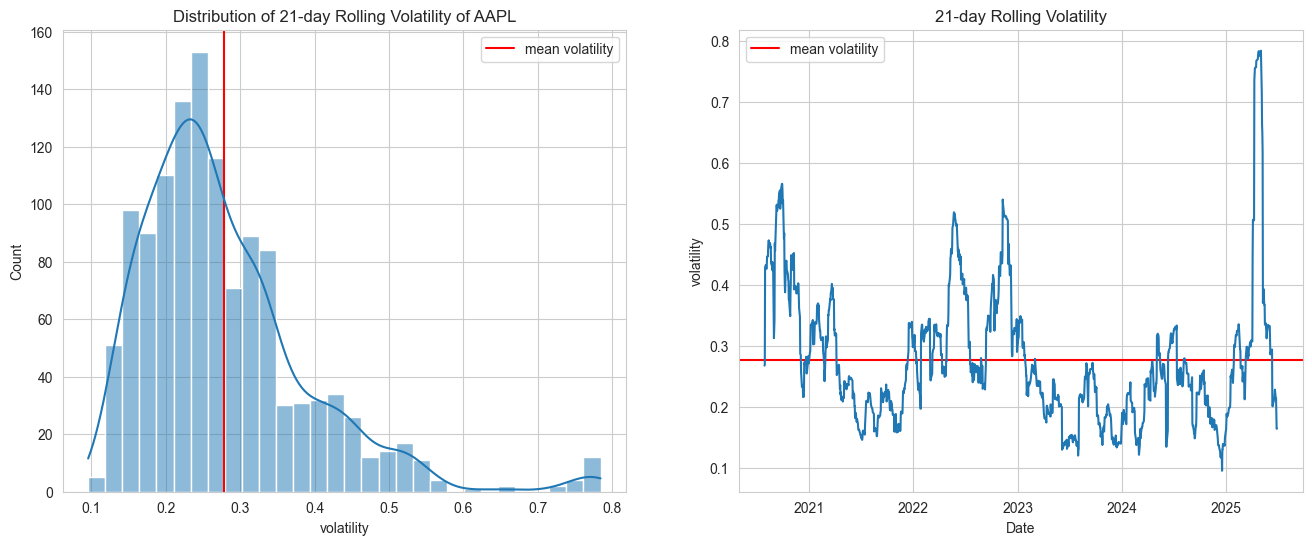

The mean of the 21-day rolling volatility of AAPL is: 0.2777


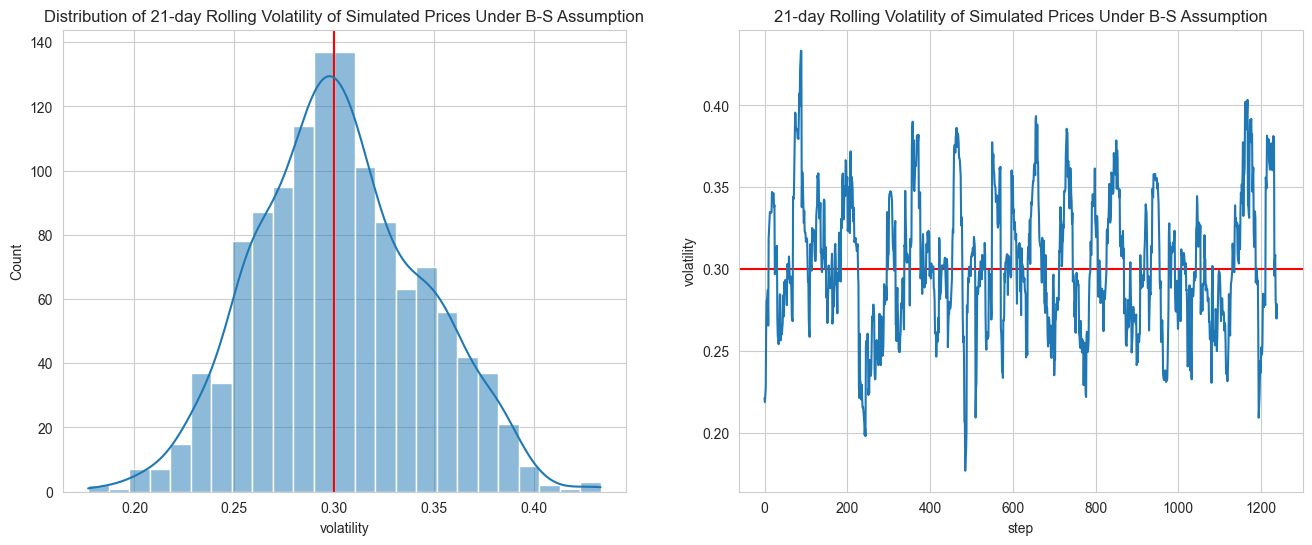

In [22]:
rolling_window = 21

market_data = ticker.history(period='5y')
log_return = np.log(market_data['Close']/market_data['Close'].shift(1)).dropna()
volatility_rolling = log_return.rolling(rolling_window).std().dropna()*np.sqrt(252)
mean = volatility_rolling.mean()

_, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title(f'Distribution of {rolling_window}-day Rolling Volatility of {symbol}')
axes[0].set_xlabel('volatility')
axes[0].axvline(mean, color='r', label='mean volatility')
axes[0].legend()
sns.histplot(volatility_rolling, kde=True, ax=axes[0])

axes[1].set_title(f'{rolling_window}-day Rolling Volatility')
axes[1].set_ylabel('volatility')
axes[1].axhline(mean, color='r', label='mean volatility')
sns.lineplot(x=volatility_rolling.index, y=volatility_rolling, ax=axes[1])
plt.show()
print(f"The mean of the {rolling_window}-day rolling volatility of {symbol} is: {volatility_rolling.mean():.4f}")

###################################################################################################

_, axes = plt.subplots(1, 2, figsize=(16, 6))
simulated_price = BS_price_simulate(100, 0.05, 0.3, 5, 252*5)
log_return = np.log(simulated_price[1:]/simulated_price[:-1])
rolling_windows = np.lib.stride_tricks.sliding_window_view(log_return, rolling_window)
volatility_rolling = np.std(rolling_windows, axis=-1)*np.sqrt(252)
axes[0].set_title(f'Distribution of {rolling_window}-day Rolling Volatility of Simulated Prices Under B-S Assumption')
axes[0].set_xlabel('volatility')
axes[0].axvline(0.3, color='r', label='sigma')
sns.histplot(volatility_rolling, kde=True, ax=axes[0])

axes[1].set_title(f'{rolling_window}-day Rolling Volatility of Simulated Prices Under B-S Assumption')
axes[1].set_ylabel('volatility')
axes[1].set_xlabel('step')
axes[1].axhline(0.3, color='r', label='sigma')
axes[1].plot(volatility_rolling)
plt.show()

| Feature                           | Black-Scholes Model            | Real Market (e.g. AAPL)        |
|-----------------------------------|--------------------------------|--------------------------------|
| Volatility level                  | Constant, fixed `σ` (e.g. 0.3) | Time-varying, fluctuates over time |
| Distribution of rolling volatility| Symmetric, roughly normal around `σ` | Skewed, often with fat right tail |
| Volatility clustering             | None, volatility is memoryless | Strong clustering: high volatility follows high, low follows low |
| Extreme volatility spikes         | Rare, due to normal shocks     | Frequent, driven by market shocks, news, crises |

---

- **Volatility clustering**: Empirical data shows volatility is autocorrelated — large changes tend to cluster together. This is different from the constant volatility assumption in BS model.

- **Heavy tails distribution**: Extreme moves are more likely than the BS model predicts. This is also why extreme rolling volatility could occur.

- **Mean-reverting volatility**: Volatility tends to revert to a long-run average over time, a feature often modeled with stochastic volatility (Heston or GARCH-type models).



## Implied volatility and the volatility smile

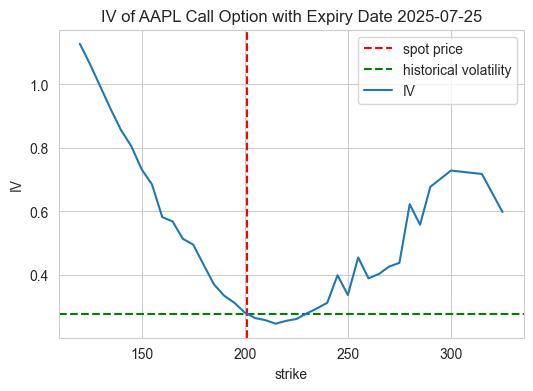

In [25]:
expiry = expiry_dates[3]
option = ticker.option_chain(expiry)
spot = market_data['Close'].iloc[-1]

plt.figure(figsize=(6, 4))
plt.ylabel('IV')
plt.title(f"IV of {symbol} Call Option with Expiry Date {expiry}")
plt.axvline(spot, color='r', linestyle='--', label='spot price')
plt.axhline(mean, color='g', linestyle='--', label='historical volatility')
sns.lineplot(data=option.calls, x='strike', y='impliedVolatility', label='IV')
plt.show()

| Model       | Volatility                                                                  | IV plot      |
|-------------|-----------------------------------------------------------------------------|--------------|
| BS Model    | constant volatility *independent of the option strike*                      | flat line    |
| Real Market | volatility *depends on the strike price*, resulting in a *volatility smile* | smile shaped |



---

- **Heavy tails distribution**: Real stock returns have a higher probability of extreme moves than the normal distribution. Market participants price in this extra risk via higher implied vols for OTM options.

- **Supply-demand effects**: Traders often hedge portfolios by buying OTM options, which increases demand and hence raises their implied volatilities.




## Delta-Hedge using BS assumption on real market

In [168]:
expiry = '2025-07-03'
expiry_date = np.datetime64(pd.to_datetime(expiry).date())
strike = 200
sigma = volatility_rolling.mean()
r = 0.043
q = 0.0052

contract = yf.Ticker('AAPL250703C00200000')
option_data = contract.history(period='max')
option_price = option_data['Close'].rename('option_price')

start_date = option_data.index[0]
spot_price = market_data[market_data.index >= start_date]['Close'].rename('spot_price')

data = pd.merge(option_price, spot_price, on='Date')
start_dates = data.index.normalize().values.astype('datetime64[D]')
data['tte'] = np.busday_count(start_dates, expiry_date) / 252
# data['tte'] = (pd.to_datetime(expiry).tz_localize(data.index[0].tz) - data.index).days / 365

def delta(df):
    bs = BlackScholes(S=df['spot_price'], K=strike, T=df['tte'], r=r, sigma=df['IV'], q=q, option_type='call')
    return bs.delta()

def bs_price(df):
    bs = BlackScholes(S=df['spot_price'], K=strike, T=df['tte'], r=r, sigma=df['IV'], q=q, option_type='call')
    return bs.price()

def IV_call(C, S, K, T, r=0.0, q=0.0, tol=1e-6, max_iterations=150):
    """Numerically solves for implied volatility."""
    if T == 0 or C < max(S - K, 0):
        return 0.0
    # Root finding in volatility between near 0 and very high volatility
    def objective(sigma):
        bs = BlackScholes(S, K, T, r, sigma, q, option_type='call')
        return bs.price()-C
    try:
        iv = brentq(objective, 1e-6, 5.0, xtol=tol, maxiter=max_iterations)
    except (ValueError, RuntimeError):
        iv = np.nan
    return iv


data['IV'] = data.apply(lambda row: IV_call(
    row['option_price'],
    row['spot_price'],
    strike,
    row['tte'],
    r,
    q=q
), axis=1)

# data['bs_price'] = data.apply(bs_price, axis=1)
data['delta'] = data.apply(delta, axis=1)

data.head(5)

,option_price,spot_price,tte,IV,delta
Date,,,,,
2025-05-27 00:00:00-04:00,8.20,200.210007,0.107143,0.294796,0.539961
2025-05-28 00:00:00-04:00,8.30,200.419998,0.103175,0.300455,0.543663
2025-05-29 00:00:00-04:00,7.82,199.949997,0.099206,0.297928,0.533283
2025-05-30 00:00:00-04:00,8.00,200.850006,0.095238,0.292102,0.552256
2025-06-02 00:00:00-04:00,8.10,201.699997,0.091270,0.283267,0.571940


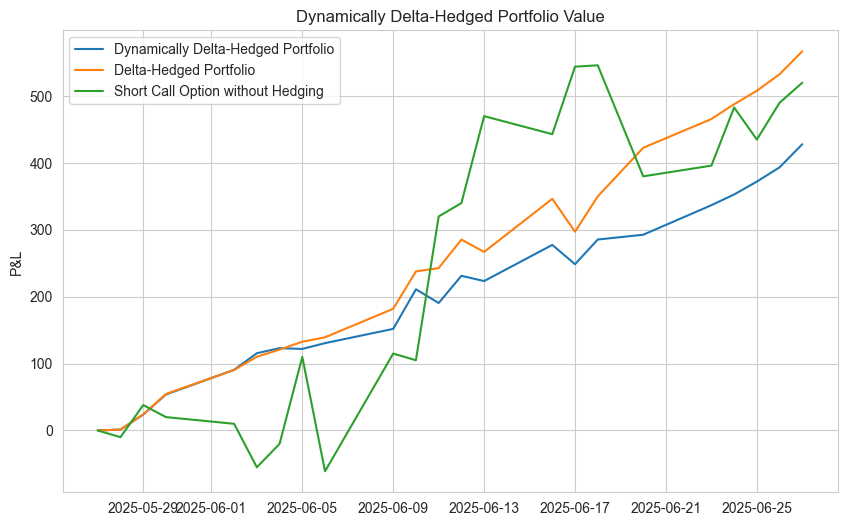

In [166]:
N_options = 100
data = data.copy()
data['hedge_shares'] = N_options * data['delta']  # number of shares held at each time

# Compute changes in hedge position (rebalancing)
data['hedge_shares_change'] = data['hedge_shares'].diff().fillna(data['hedge_shares'])

# Cash flows from rebalancing the stock hedge
# Buying shares (positive change) costs money (cash decreases)
# Selling shares (negative change) raises money (cash increases)
data['cashflow'] = -data['hedge_shares_change'] * data['spot_price']

# Cumulative cash position
data['cash'] = data['cashflow'].cumsum()


# Value of positions
data['option_position'] = -N_options * data['option_price']
data['stock_position'] = data['hedge_shares'] * data['spot_price']

data['cash'] -= data['option_position'].iloc[0]

# Total portfolio value
data['portfolio_value'] = data['cash'] + data['option_position'] + data['stock_position']

# Show results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(data.index, data['portfolio_value'], label='Dynamically Delta-Hedged Portfolio')

fixed_delta = data['delta'].iloc[0]
portfolio_value = -100*data['option_price']+fixed_delta*100*data['spot_price']
portfolio_value_change = portfolio_value-portfolio_value.iloc[0]
plt.plot(portfolio_value_change.index, portfolio_value_change, label='Delta-Hedged Portfolio')

plt.plot(data.index, -100*data['option_price']+100*data['option_price'].iloc[0], label="Short Call Option without Hedging")
plt.legend()
plt.ylabel("P&L")
plt.legend()
plt.title('Dynamically Delta-Hedged Portfolio Value')
plt.show()

## GARCH model for volatility

TODO
1. Analyze the historical volatility vs implied volatility
2. Some Volatility model, and delta hedging simulation on real market data



- **Implied volatility surfaces**, i.e. functions of both strike and maturity, to price and hedge options.
- More advanced models such as **local volatility models (Dupire)**, **stochastic volatility (Heston, SABR)**, or **jump-diffusion models (Merton)** to better fit market prices.